In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler

from matplotlib import style
style.use('dark_background')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
style.use('dark_background')

In [2]:
#reads document and standardizes user scores

df = pd.read_csv('gamereviews.csv')
df = df.drop(df.columns[[0, 1, 5]], axis=1)
df.dropna(inplace=True)
df['Userscore'] = StandardScaler().fit_transform(df[['Userscore']])

print(df.head(), df['Userscore'].describe())

     Platform  Userscore                                            Comment
0  Nintendo64   0.760493  Everything in OoT is so near at perfection, it...
1  Nintendo64   0.760493  I won't bore you with what everyone is already...
2  Nintendo64   0.760493  Anyone who gives the masterpiece below a 7 or ...
3  Nintendo64   0.760493  I'm one of those people who think that this is...
4  Nintendo64   0.760493   This game is the highest rated game on Metacr... count    2.839600e+05
mean    -2.562318e-17
std      1.000002e+00
min     -2.432663e+00
25%     -1.974537e-01
50%      4.411776e-01
75%      7.604933e-01
max      7.604933e-01
Name: Userscore, dtype: float64


In [3]:
#converts scores to sentiment

df['Polarity'] = df['Userscore'].apply(lambda x: 'Positive' if (x > .76) else('Neutral' if (x <= .76) and (x >= -.197)  else 'Negative'))
df.head()

,Platform,Userscore,Comment,Polarity
0,Nintendo64,0.760493,"Everything in OoT is so near at perfection, it...",Positive
1,Nintendo64,0.760493,I won't bore you with what everyone is already...,Positive
2,Nintendo64,0.760493,Anyone who gives the masterpiece below a 7 or ...,Positive
3,Nintendo64,0.760493,I'm one of those people who think that this is...,Positive
4,Nintendo64,0.760493,This game is the highest rated game on Metacr...,Positive


<AxesSubplot:>

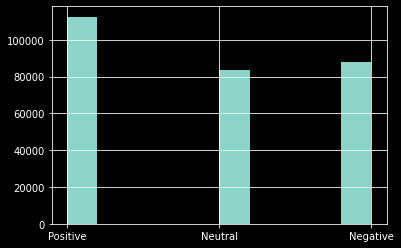

In [4]:
df['Polarity'].hist()

In [5]:
#function to get rid of stopwords and all non-letter characters

def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [6]:
#applies function and also converts all letters to lowercase

df['Comment'] = df['Comment'].apply(get_text_processing)
df['Comment'] = df['Comment'].str.lower()
df.head()

,Platform,Userscore,Comment,Polarity
0,Nintendo64,0.760493,everything oot near perfection really wonder g...,Positive
1,Nintendo64,0.760493,wont bore everyone already saying amazing game...,Positive
2,Nintendo64,0.760493,anyone gives masterpiece 7 8 either hate astou...,Positive
3,Nintendo64,0.760493,im one people think greatest game time matter ...,Positive
4,Nintendo64,0.760493,game highest rated game metacritic good reason...,Positive


In [7]:
#for sparse categorical cross entropy loss function

n = df['Userscore'].apply(lambda x: 2 if (x > .76) else(1 if (x <= .76) and (x >= -.197)  else 0))
n.head()

0    2
1    2
2    2
3    2
4    2
Name: Userscore, dtype: int64

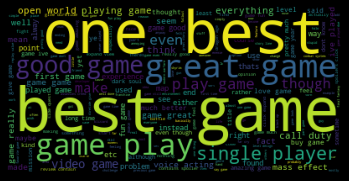

In [8]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(df['Comment']))

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [9]:
#one hot encode polarity

p = df['Polarity']
onehot = pd.get_dummies(p)
df.drop(['Polarity', 'Platform', 'Userscore'], axis=1, inplace=True)
df = pd.concat([df, onehot], axis=1)
df = df.reset_index(drop=True)
df

,Comment,Negative,Neutral,Positive
0,everything oot near perfection really wonder g...,0,0,1
1,wont bore everyone already saying amazing game...,0,0,1
2,anyone gives masterpiece 7 8 either hate astou...,0,0,1
3,im one people think greatest game time matter ...,0,0,1
4,game highest rated game metacritic good reason...,0,0,1
...,...,...,...,...
283955,extremely similar eo4 obviously isnt bad thing...,1,0,0
283956,typical overrated atlus trash game liked since...,1,0,0
283957,find story mode annoying characters intrusive ...,0,1,0
283958,pretty good certainly lacks visual audio polis...,0,1,0


In [10]:
X = df['Comment']
y = df.drop('Comment', axis=1)
print(X, y)

0         everything oot near perfection really wonder g...
1         wont bore everyone already saying amazing game...
2         anyone gives masterpiece 7 8 either hate astou...
3         im one people think greatest game time matter ...
4         game highest rated game metacritic good reason...
                                ...                        
283955    extremely similar eo4 obviously isnt bad thing...
283956    typical overrated atlus trash game liked since...
283957    find story mode annoying characters intrusive ...
283958    pretty good certainly lacks visual audio polis...
283959    first game etrian series hard time got used ch...
Name: Comment, Length: 283960, dtype: object         Negative  Neutral  Positive
0              0        0         1
1              0        0         1
2              0        0         1
3              0        0         1
4              0        0         1
...          ...      ...       ...
283955         1        0         0
283956 

In [ ]:
#apply lancaster stemming

import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

lancaster = LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

XS = pd.DataFrame(X)
for i in range(0, len(X)):
    XS.loc[i] = stemSentence(X[i])
    
print(XS)

In [ ]:
#dim reduction by freq filtering

vect = CountVectorizer(strip_accents = 'unicode', max_df = .995, min_df = .005)
XX = vect.fit_transform(XS['Comment'])

tfidf = TfidfTransformer()
XX = tfidf.fit_transform(XX)
XX.shape

In [ ]:
#dim reduction by SVD

from numpy import array
from scipy.sparse.linalg import svds

u, s, v = svds(XX)
u.shape

In [ ]:
#dim reduction by clustering

import numpy as np
from sklearn import datasets, cluster

agglo = cluster.FeatureAgglomeration(n_clusters = 42)
agglo.fit(XX.toarray())
XR = agglo.transform(XX.toarray())
XR.shape

In [ ]:
#train test split for each reduced df

from sklearn.model_selection import train_test_split

xtr, xte, ytr, yte = train_test_split(XX, p, test_size = 0.2, random_state = 42)
xtru, xteu, ytru, yteu = train_test_split(u, p, test_size = 0.2, random_state = 42)
xtrr, xter, ytrr, yter = train_test_split(XR, p, test_size = 0.2, random_state = 42)

In [ ]:
#packages for validation

from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

report = pd.DataFrame()

In [ ]:
knn = KNeighborsClassifier(300)
knn.fit(xtr, ytr)
ypr = knn.predict(xte)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#freq filtered model: accuracy of .41, not a good model

In [ ]:
knn = KNeighborsClassifier(300)
knn.fit(xtru, ytru)
ypr = knn.predict(xteu)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#SVD model: accuracy of .54, better than before

In [ ]:
knn = KNeighborsClassifier(300)
knn.fit(xtrr, ytrr)
ypr = knn.predict(xter)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#clustered model: accuracy of .51, relatively ok performance

In [ ]:
gnb = GaussianNB()
gnb.fit(xtru, ytru)
ypr = gnb.predict(xteu)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#skipped freq filtered df: GNB can't be performed on sparse matrix
#SVD model: accuracy of .48, worse than KNN but much faster 

from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
bayes = GaussianNB()
visualizer = ClassificationReport(bayes, classes=['Negative', 'Neutral', 'Positive'], support=True)

visualizer.fit(xtru, ytru)  # Fit the visualizer and the model
visualizer.score(xteu, yteu)  # Evaluate the model on the test data
visualizer.show()             # Draw/show the data

In [ ]:
gnb = GaussianNB()
gnb.fit(xtrr, ytrr)
ypr = gnb.predict(xter)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#clustered model: accuracy of .5, same as above

In [ ]:
#random forest was considered, but it is infeasible due to compute resources required

In [ ]:
clf = make_pipeline(StandardScaler(), 
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(xtru, ytru)
ypr = clf.predict(xteu)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

##skipped freq filtered df: SVC can't be performed on sparse matrix
#SVD model: accuracy of .53, relatively good and fast performance

In [ ]:
clf = make_pipeline(StandardScaler(), 
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(xtrr, ytrr)
ypr = clf.predict(xter)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#clustered model: accuracy of .55, best performance so far

In [ ]:
#filtered freq df: highest accuracy of all models so far, but has high loss

xtrnn, xtenn, ytrnn, ytenn = train_test_split(XX.toarray(), n, test_size = 0.2, random_state = 42)

model1 = Sequential()
model1.add(Dense(units=300, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(units=300, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(units=300, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(units=30, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt, 
              metrics=['accuracy'])
model1.fit(xtrnn, ytrnn, epochs = 4)

In [ ]:
#filtered freq df: .75 loss with .68 accuracy

vloss1, vacc1 = model1.evaluate(xtenn, ytenn)
vloss1, vacc1

In [ ]:
yprnn = model1.predict(xtenn)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

In [ ]:
#SVD df: worst performance of NN models

xtrnn, xtenn, ytrnn, ytenn = train_test_split(u, n, test_size = 0.2, random_state = 42)

model2 = Sequential()
model2.add(Dense(units=300, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=300, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=300, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=30, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt, 
              metrics=['accuracy'])

model2.fit(xtrnn, ytrnn, epochs = 4)

In [ ]:
#SVD df: .96 loss with .53 accuracy

vloss2, vacc2 = model2.evaluate(xtenn, ytenn)
vloss2, vacc2

In [ ]:
yprnn = model2.predict(xtenn)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

In [ ]:
#clustered df: bad performance for NN

xtrnn, xtenn, ytrnn, ytenn = train_test_split(XR, n, test_size = 0.2, random_state = 42)

model3 = Sequential()
model3.add(Dense(units=300, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=300, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=300, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=30, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt, 
              metrics=['accuracy'])

model3.fit(xtrnn, ytrnn, epochs = 4)

In [ ]:
#clustered df: .92 loss with .55 accuracy

vloss3, vacc3 = model3.evaluate(xtenn, ytenn)
vloss3, vacc3

In [ ]:
yprnn = model3.predict(xtenn)
print(confusion_matrix(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())